## Goals to complete:
- Build raw neural network
- Use Keras Resnet50

## Steps:
1. **Write python file to seperate images**
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n
2. **Visualize data**
3. **Create image generator**
4. **Load data**
5. **Create model**
6. **Fit model**
7. **Plot history**
8. **Check overfitting**
9. **Get result**

## Notes:
- (Accuracy -- Val_accuracy) and (Loss -- Val_loss): Check overfitting
- MaxPooling2D: Reduce image size

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Visualize data

(374, 500, 3)


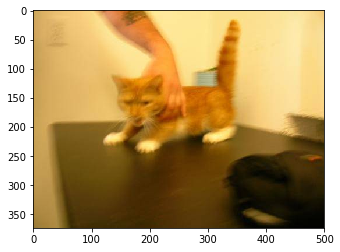

In [2]:
cat0 = cv2.imread('dataset/train/cat/cat.0.jpg')
cat0 = cv2.cvtColor(cat0, cv2.COLOR_BGR2RGB)
print(cat0.shape)

plt.imshow(cat0)

(375, 499, 3)


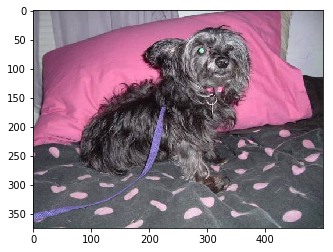

In [3]:
dog0 = cv2.imread('dataset/train/dog/dog.0.jpg')
dog0 = cv2.cvtColor(dog0, cv2.COLOR_BGR2RGB)
print(dog0.shape)

plt.imshow(dog0)

### Create ImageDataGenerator

In [4]:
image_gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2,
                               fill_mode='nearest')

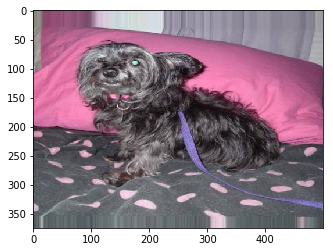

In [5]:
plt.imshow(image_gen.random_transform(dog0))

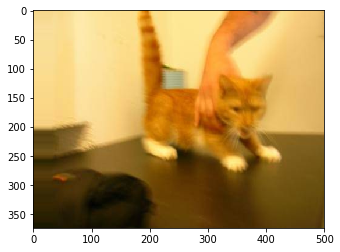

In [6]:
plt.imshow(image_gen.random_transform(cat0))

### Load data

In [7]:
directory = 'dataset/train'
batch_size = 32
image_shape = (127, 127, 3)

train_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='training')

test_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


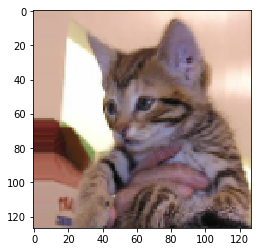

In [8]:
plt.imshow(train_data[0][0][4])

In [9]:
print(train_data.samples, test_data.samples)

20000 5000


### Create model

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=image_shape),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    
    Dense(500, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0

### Fit model

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

In [14]:
results = model.fit_generator(train_data,
                              epochs=25,
                              validation_data=test_data,
                              validation_steps=test_data.samples//batch_size,
                              steps_per_epoch=train_data.samples//batch_size,
                              callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 156 steps
Epoch 1/25
154/625 [======>.......................] - ETA: 1:30 - loss: 0.7131 - accuracy: 0.5235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [ ]:
model.save('model.h5')

### Plot history

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].plot(results.history['accuracy'], label='Train accuracy')
ax[0].plot(results.history['val_accuracy'], label='Validation accuracy')
ax[0].legend(['Train accuracy', 'Validation accuracy'])

ax[1].plot(results.history['loss'], label='Train loss')
ax[1].plot(results.history['val_loss'], label='Validation loss')
ax[1].legend(['Train loss', 'Validation loss'])

plt.show()

### Get result

In [ ]:
test_filenames = os.listdir('dataset/test/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df,
    'dataset/test/test',
    target_size=image_shape[:2],
    batch_size=batch_size,
    x_col='filename',
    y_col=None,
    class_mode=None,
    shuffle=False
)

In [ ]:
predictions = model.predict_generator(test_set)

In [ ]:
test_df['label'] = np.argmax(predictions, axis=1)

In [ ]:
test_df['id'] = test_df['filename'].str.split('.').str[0]
test_df = test_df.drop('filename', axis=1)

In [ ]:
test_df.to_csv(path_or_buf='result.csv', index=False)